# Проект: Компьютерные игры.

### Описание проекта

Интернет-магазин продаёт по всему миру компьютерные игры.   
Из открытых источников доступны данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

Задача - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. 

### 1 Откроем файл с данными и изучим общую информацию о данных в нем. 

In [1]:
# Все import соберем в начале проекта:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

pd.set_option('display.max_columns', None) # Не ограничиваем максимальное количество отображающихся столбцов

%config InlineBackend.figure_format = 'svg'

In [2]:
print(matplotlib.__version__)
print(matplotlib.get_backend()) # Проверим, какой графический движок используем:

3.3.4
module://matplotlib_inline.backend_inline


**Загрузка локального и удаленного файла с данными:**

Изучили файл с предоставленными данными **games.csv** и решили использовать символ **запятая** для разделения данных:

In [3]:
dataset_remote_path = 'https://.../datasets/games.csv' # /datasets/games.csv
dataset_local_path = 'datasets/games.csv'  

try:
    data = pd.read_csv(dataset_local_path, sep=',')
    print('Local dataset is loaded.')
except:
    data = pd.read_csv(dataset_remote_path, sep=',')
    print('Remote dataset is loaded.')

# Посмотрим, что за данные находятся в изучаемом файле:    
data.head()

Local dataset is loaded.


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В нашем dataset всего 11 столбцов со следующей информацией:
* **Name** — название игры
* **Platform** — платформа
* **Year_of_Release** — год выпуска
* **Genre** — жанр игры
* **NA_sales** — продажи в Северной Америке (миллионы проданных копий)
* **EU_sales** — продажи в Европе (миллионы проданных копий)
* **JP_sales** — продажи в Японии (миллионы проданных копий)
* **Other_sales** — продажи в других странах (миллионы проданных копий)
* **Critic_Score** — оценка критиков (максимум 100)
* **User_Score** — оценка пользователей (максимум 10)
* **Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


### 2 Предварительная обработка данных

**2.1. Корректировка названий столбцов**

Видим, что в названии столбцов есть заглавные символы. Заменим их все на символы с нижним регистром.

In [4]:
columns = data.columns.tolist()  # Создадим список из названий столбцов
columns = [ch.lower() for ch in columns]  #Переводим все буквы в нижний регистр
data.columns = columns  # Передаем обновленный список названиям столбцов

Проверим правильность написания названий столбцов:

In [5]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Все в порядке. Названия столбцов приведены к стилю **snake_case**.

Посмотрим, как теперь выглядит наш dataset:

In [6]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**2.2. Изучим размер нашего массива данных и запомним исходное количество строк:**

In [7]:
data.shape, data.size

((16715, 11), 183865)

Набор данных довольно большой. **16 715 строк х 11 столбцов!**

**2.3. Поиск дубликатов**

In [8]:
data.duplicated().sum()

0

Отлично! **Дубликатов в нашей таблице нет.**

Выведем основную информацию с помощью метода info()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**2.4. Проверка и корректировка типов данных**

Изучим тип данных:

* name — название игры. Тип object - все в порядке.
* platform — платформа. Тип object - тоже все хорошо.
* **year_of_release** — год выпуска. Тип float. У нас это не дата, а только значение года. Сейчас оно в формате float, а нужно **изменить на тип int!**
* genre — жанр игры. Тип object - все правильно.
* na_sales — продажи в Северной Америке (миллионы проданных копий). Тип float - да, это так.
* eu_sales — продажи в Европе (миллионы проданных копий). Тип float - корректно.
* jp_sales — продажи в Японии (миллионы проданных копий). Тип float - замечательно!
* other_sales — продажи в других странах (миллионы проданных копий). Тип float - отлично!
* critic_score — оценка критиков (максимум 100). Тип float. В порядке.
* **user_score** — оценка пользователей (максимум 10). Тип object. Но на самом деле значения находятся в диапазоне от 0 до 10 и представляют собой числа с точностью до 1 десятой. Поэтому **меняем на тип float**
* rating — рейтинг от организации ESRB. Тип object - оставляем.

**2.4.1. Корректировка поля year_of_release**

In [10]:
# проверим, что за данные были:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [11]:
# меняем тип данных на int
data['year_of_release'] = data['year_of_release'].astype('Int64')

In [12]:
# проверяем:
data['year_of_release'].unique()

<IntegerArray>
[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004,
 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997, 1993, 1994,
 1982, 2016, 2003, 1986, 2000, <NA>, 1995, 1991, 1981, 1987, 1980, 1983]
Length: 38, dtype: Int64

Теперь все хорошо. Смотрим следующее поле.

**2.4.2. Корректировка поля user_score**

In [13]:
# проверим тип данных:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Интересно! При попытке изменения типа получаем ошибку:
*ValueError: could not convert string to float: 'tbd'*

Действительно, такое необычное значение тут есть. Вполне возможно, что *tbd* означает *to be discussed*, т.е., его не смогли определить на момент включения в базу данных. Мы тоже этого теперь сделать не сможем.
Поменяем его на *nan*, чтобы можно было работать с этим столбцом, тем более, что такие значения здесь уже есть.

In [14]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')

In [15]:
# Вот теперь можем изменить тип:
data['user_score'] = data['user_score'].astype('float')
# И проверим данные:
data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


С типами данных разобрались. Теперь займемся пропусками.

**2.5. Изучим пропущенные данные**

In [17]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Видим, что 5 столцов имеют пропуски данных: 
* name
* year_of_release
* critic_score
* user_score
* rating
Изучим каждый из них.

**2.5.1. Пропуски в name**

В этом поле всего 2 пропуска. Это мало по сравнению с общим количеством в 16715 строк. Тем не менее, сразу удалять не будем. Посмотрим, что за информация содержится в столбце *name*:

In [18]:
data['name'].unique()

array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii', ...,
       'Woody Woodpecker in Crazy Castle 5', 'LMA Manager 2007',
       'Haitaka no Psychedelica'], dtype=object)

Названия игр - строки переменной длины. 
Посмотрим полностью обе записи с пропущенными названиями игр:

In [19]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Увы, в этих двух записях много пропусков: название игры, жанр игры, оценка критиков, оценка пользователей, рейтинг ESRB.

Посмотрим, какие игры выпускались для платформы *GEN* в 1993 году:

In [20]:
data.query('platform == "GEN"').sort_values('year_of_release', ascending = False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14488,Puzzle & Action: Tant-R,GEN,1994,Misc,0.00,0.00,0.03,0.00,NaN,NaN,NaN
996,Sonic the Hedgehog 3,GEN,1994,Platform,1.02,0.47,0.20,0.07,NaN,NaN,NaN
9000,"Lunar 2: Eternal Blue(sales, but wrong system)",GEN,1994,Role-Playing,0.00,0.00,0.14,0.00,NaN,NaN,NaN
6451,Virtua Racing,GEN,1994,Racing,0.00,0.00,0.26,0.00,NaN,NaN,NaN
1842,NBA Jam Tournament Edition,GEN,1994,Sports,0.95,0.14,0.00,0.03,NaN,NaN,NaN
1453,Mortal Kombat 3,GEN,1994,Fighting,1.03,0.27,0.00,0.04,NaN,NaN,NaN
11563,Yuu Yuu Hakusho: Makyo Toitsusen,GEN,1994,Fighting,0.00,0.00,0.08,0.00,NaN,NaN,NaN
1365,Disney's The Lion King,GEN,1994,Platform,0.97,0.37,0.03,0.05,NaN,NaN,NaN
960,Sonic & Knuckles,GEN,1994,Platform,1.24,0.43,0.03,0.12,NaN,NaN,NaN
14085,J-League Pro Striker 2,GEN,1994,Sports,0.00,0.00,0.04,0.00,NaN,NaN,NaN


Видим, что для платформы *GEN* в *1993* году было выпущено 7 игр. Плюс к ним есть 2 изучаемые нами записи с пропусками.
К сожалению, мы не можем идентифицировать эти две игры и поэтому принимаем решение расстаться с ними.

In [21]:
data = data.dropna(subset = ['name'])

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


Проверка показалв, что 2 записи удалены. Среди названий игр больше пропусков нет

**2.5.2. Пропуски в данных - год выпуска игры**

In [23]:
# Посчитаем количество пустых значений в столбце year_of_release
data['year_of_release'].isna().sum()

269

In [24]:
# Посмотрим, что из себя представляют записи с пропущенным значенеим года выпуска:
data[data['year_of_release'].isnull() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,<NA>,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Первым в списке с пустым значением **year_of_release** видим игру *Madden NFL 2004*. Посмотрим информацию о ней:

In [25]:
data.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Видим, что игра *Madden NFL 2004* выпущена на разных платформах в 2003 году.

Посмотрим информацию о следующей, *FIFA Soccer 2004*:

In [26]:
data.query('name == "FIFA Soccer 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2606,FIFA Soccer 2004,XB,2003,Sports,0.24,0.49,0.00,0.05,82.0,8.2,E
12029,FIFA Soccer 2004,GC,2003,Sports,0.05,0.01,0.00,0.00,83.0,6.2,E
13086,FIFA Soccer 2004,GBA,2003,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E


Хм, *FIFA Soccer 2004* выпущена на разных платформах тоже 2003 году.

Посмотрим что-нибудь из середины списка, например *Madden NFL 11*:

In [27]:
data.query('name == "Madden NFL 11"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
561,Madden NFL 11,X360,2010,Sports,2.38,0.12,0.0,0.18,84.0,5.7,E
661,Madden NFL 11,PS3,2010,Sports,2.04,0.15,0.0,0.20,83.0,6.1,E
2849,Madden NFL 11,Wii,<NA>,Sports,0.68,0.00,0.0,0.04,75.0,5.4,E
3987,Madden NFL 11,PS2,2010,Sports,0.41,0.02,0.0,0.07,NaN,7.0,E
5049,Madden NFL 11,PSP,2010,Sports,0.35,0.00,0.0,0.03,NaN,NaN,E


Интересно! *Madden NFL 11* выпущена на разных платформах 2010 году. В одном и том же году!

Посмотрим что-то их конца списка:

In [28]:
data.query('name == "Freaky Flyers"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10551,Freaky Flyers,PS2,2003,Racing,0.05,0.04,0.0,0.01,66.0,NaN,T
14532,Freaky Flyers,XB,2003,Racing,0.02,0.01,0.0,0.00,64.0,NaN,T
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.0,0.00,69.0,6.5,T


Можем сделать предположение, что **одна и та же игра выходила на разных платформах в один и тот же год!**

Принимаем решение компенсировать отсутствующие значения года выпуска игры значением года выпуска ее на других платформах (или наиболее часто встречающимся значением). Конечно, если такая информация существует.

In [29]:
for num in data[data['year_of_release'].isnull() == True].index:  
    data['year_of_release'][num] = data.loc[data['name'] == data['name'][num], 'year_of_release'].max()

# Посмотрим, сколько пропусков в year_of_release осталось:
data['year_of_release'].isna().sum()    

146

Видим, что количество строк, в которых отсутствует значение *year_of_release*, сократилось с 269 до 146.

Посмотрим, а что за пропуски остались в этом поле:

In [30]:
data[data['year_of_release'].isnull() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
627,Rock Band,X360,<NA>,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.00,0.07,73.0,NaN,E
805,Rock Band,Wii,<NA>,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T
1142,Rock Band,PS3,<NA>,Misc,0.99,0.41,0.00,0.22,92.0,8.4,T
...,...,...,...,...,...,...,...,...,...,...,...
16277,Homeworld Remastered Collection,PC,<NA>,Strategy,0.00,0.01,0.00,0.00,86.0,8.2,E10+
16288,Shorts,DS,<NA>,Platform,0.01,0.00,0.00,0.00,NaN,NaN,E10+
16348,Agarest Senki: Re-appearance,PS3,<NA>,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [31]:
data.query('name == "wwe Smackdown vs. Raw 2006"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.0,0.41,NaN,NaN,NaN


In [32]:
data.query('name == "Rock Band"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
627,Rock Band,X360,<NA>,Misc,1.93,0.33,0.0,0.21,92.0,8.2,T
805,Rock Band,Wii,<NA>,Misc,1.33,0.56,0.0,0.20,80.0,6.3,T
1142,Rock Band,PS3,<NA>,Misc,0.99,0.41,0.0,0.22,92.0,8.4,T
1840,Rock Band,PS2,<NA>,Misc,0.71,0.06,0.0,0.35,82.0,6.8,T


Можем сделать вывод, что пропущенные значения года выпуска остались незаполненными только для единичных записей, которые мы никак не можем заполнить. А потому удалим эти 146 строк:

In [33]:
data = data.dropna(subset = ['year_of_release'])

In [34]:
# посмотрим, какой датасет у нас получился:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  Int64  
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   critic_score     8075 non-null   float64
 9   user_score       7540 non-null   float64
 10  rating           9868 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


**2.5.3. Пропуски данных в *critic_score* - оценка критиков, *user_score* - оценка пользователей**

Посмотрим пропущенные данные:

In [35]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 13.])

Изучим статистику по оценкам критиков:

In [36]:
data['critic_score'].describe()

count    8075.000000
mean       68.991950
std        13.923383
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

**Отмечаем, что:**
* На шкале  0 - 100 баллов оценки критиков находятся в щироком диапазоне от 13 до 98! 
* Наиболее часто оценки лежат в пределах от 60 до 80 баллов. 
* Среднее и медианное значения хорошо согласуются (соответственно 69 и 71).

In [37]:
data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Посмотрим статистику по оценкам пользователей:

In [38]:
data['user_score'].describe()

count    7540.000000
mean        7.125027
std         1.498254
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

**Можем зафиксировать:**
* Шкала, по которой пользователи оценивали игры: от 0 до 10 с одним знаком после запятой. 
* Оценки ставились по всему дипазону, от 0 (min) до 9.7 (max). 
* Наиболее популярные оценки в области 6.4 - 8.2 балла.
* Среднее и медианное значения согласуются удовлетворительно (соответственно 7.1 и 7.5).

**Общий вывод по пропускам в полях *critic_score* и *user_score*:**

Значения оценок критиков и пользователей очень специфичны. Мы не можем самостоятельно их заполнить так, чтобы не исказить статистическую картину.
В связи с большим количеством таких пропущенных данных (около половины), принимаем решение их не трогать и оставить, как есть.

**2.5.4. Пропуски данных в поле rating - рейтинг ESRB**

Рассмотрим рейтинговый список, созданный компанией ESRB:

In [39]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Информацию по рейтинговой компании ESRB найдем на официальном сайте: https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board

Попробуем разобраться с их **условными обозначениями**:
* «E» («Everyone») — «Для всех». Содержание подходит для всех возрастов. 
* «M» («Mature») — «Для взрослых». Материалы игры не подходят для лиц младше 17 лет. 
* «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.
* «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»:
* "K-A" ("Kids to Adults"). «Для всех». Это первоначальное название такого рейтинга. В настояшее авремя заменено на «E» («Everyone»). 
* «AO» («Adults Only 18+») — «Только для взрослых». 
* «EC» («Early childhood») — «Для детей младшего возраста».
* «RP» («Rating Pending») — «Рейтинг ожидается». Это означает, что продукт был направлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

Судя по данным сайта https://www.esrb.org/history/ компания ESRB была основана в 1994 году. А в нашем списке присутствуют игры, начиная с 1980 года. Поэтому, естествеено, наличие большого количества пропусков в этом поле. 
Согласно data.info(), примененному выше, из общего размера в 15657 строк, значения raning есть только в 9868. 

Посмотрим распределение этих рейтингов:

In [40]:
data['rating'].value_counts()

E       3958
T       2930
M       1554
E10+    1412
EC         8
K-A        3
RP         2
AO         1
Name: rating, dtype: int64

Так как рейтинг "K-A" - это тоже самое, что и "E", несмотря на то, что таких записей всего 3, сохраним их, переименуя в "E"

In [41]:
# Посмотрим записи с рейтингом "K-A"
data[data['rating'] == "K-A"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
656,Theme Hospital,PC,1997,Strategy,2.30,0.10,0.00,0.00,NaN,9.0,K-A
903,PaRappa The Rapper,PS,1996,Misc,0.26,0.16,1.46,0.03,92.0,7.4,K-A
16681,Worms 2,PC,1997,Strategy,0.00,0.01,0.00,0.00,NaN,8.1,K-A


Точно также, единственную запись с рейтингом *«AO» («Adults Only 18+») — «Только для взрослых»* объединим с категорией *«M» («Mature») — «Для взрослых»*. 

In [42]:
# Посмотрим записи с рейтингом "K-A"
data[data['rating'] == "AO"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
875,Grand Theft Auto: San Andreas,XB,2005,Action,1.26,0.61,0.0,0.09,93.0,8.6,AO


In [43]:
# Поменяем значения "K-A" на "E":
data.loc[(data.rating == "K-A"), 'rating'] = 'E'
# зпменим значения "AO" на "M":
data.loc[(data.rating == "AO"), 'rating'] = 'M'

# Проверим правильность замены:
print(data.loc[656]['rating'])
print(data.loc[903]['rating'])
print(data.loc[16681]['rating'])
print(data.loc[875]['rating'])

E
E
E
M


In [44]:
data['rating'].value_counts()

E       3961
T       2930
M       1555
E10+    1412
EC         8
RP         2
Name: rating, dtype: int64

Все в порядке. Видим, что:
* значений "K-A" больше нет, зато количество значений "E" увеличилось на 3.
* "AO" тоже больше нет, а число значений "M" возросло на 1.

Остальные малочисленные данные ни менять, ни убирать не будем. Оставим их истинные значения.

Для дальнейшей работы создадим:
* словарь рейтингов ESRB. 
* подпрограммку для добавления колонки rating_full_name в датасет.

In [45]:
rating_ESRB = {'E':'Для всех',
               'M':'Взрослым',
               'T':'Подросткам',
               'E10+':'10 +',
               'EC':'Для детей младшего возраста',
               'RP':'Рейтинг ожидается'} 

def rating_full_name(df):
    list_rating_full_name = []
    for i in range(len(df)):
        list_rating_full_name.append(rating_ESRB[df['rating'][df.index[i]]])

    df['rating_full_name'] = list_rating_full_name
    return df

**2.5.5. Оценим количество удаленных строк и какую долю от всех исходных данных они составляют.**

В файле **games.csv** присутствует 16715 строк. После всех сокращений их количество найдем в data.shape[0].

In [46]:
print('Количество сокращенных строк: {:.0f}'.format(16715-data.shape[0]))
print('Доля сокращенных строк: {:.2%}'.format((16715-data.shape[0])/16715))

Количество сокращенных строк: 148
Доля сокращенных строк: 0.89%


**В связи с малым количеством сокращенных данных (менее 1%) принимаем количество утерянной информации приемлемой для проведения дальнейших исследований**.

### 3 Исследовательский анализ данных

**3.1 Введем новый столбец, содержащий информацию о суммарных продажах, включая Северную Америку, Европу, Японию и другие страны (в миллионах проданных копий)**

In [47]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [48]:
amount_games_by_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')

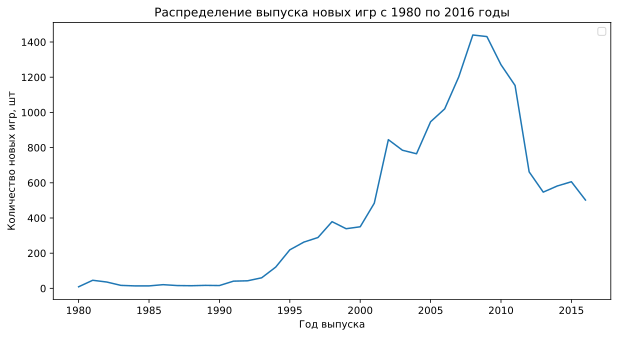

In [49]:
plt.figure(figsize=(10,5))
sns.lineplot(data=amount_games_by_year)
# sns.set_style('darkgrid')
plt.title("Распределение выпуска новых игр с 1980 по 2016 годы")
plt.xlabel("Год выпуска")
plt.ylabel("Количество новых игр, шт")
plt.legend('');

Замечаем, что производство и выпуск новых компьютерных игр сильно увеличивался начиная с 90-х и до 2008 года а затем так же резко стал падать.

**3.3 Распределение продаж игр по платформам**

Краткая история игровой индустрии в разбивке по платформам описана здесь: https://habr.com/ru/company/miip/blog/312884/

#### **3.3.1. График «ящик с усами» по глобальным продажам игр в разбивке по платформам.**

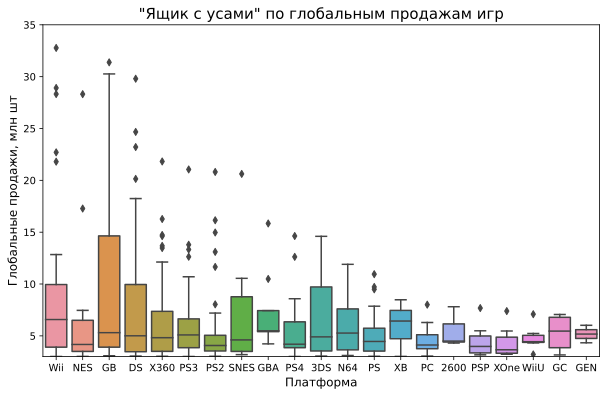

In [50]:
# Для построения графика подготовим выборку по платформам с суммарными продажами более 3 млн игр
sales_limit = 3
sales_more_3_million = data[data['total_sales'] > sales_limit]

plt.figure(figsize=(10,6))
sns.boxplot(data=sales_more_3_million, x='platform', y='total_sales')
plt.title('"Ящик с усами" по глобальным продажам игр', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylim(sales_limit, 35)
plt.ylabel('Глобальные продажи, млн шт',fontsize=12);

**Отметим несколько закономерностей:**
* Наиболее эффективные продажи на платформах *Wii*, *XB*. Медианное значение (или 50% квантиль) для них самое большое - более, чем 6 млн проданных игр.
* Для всех платформ характерно наличие выбросов в области высоких значений продаж. 

Кроме графика, посмотрим все это в цифрах и изучим, к чему приводят выбросы в значениях количества продаж:

In [51]:
sales_more_3_million.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
2600,3.0,5.540000,1.968172,4.31,4.4050,4.500,6.1550,7.81
3DS,18.0,6.753889,3.796427,3.05,3.5425,4.905,9.7175,14.60
DS,38.0,8.071579,6.959084,3.05,3.4700,5.005,9.9525,29.80
GB,17.0,10.532941,9.543365,3.08,3.9100,5.310,14.6400,31.38
GBA,8.0,7.328750,3.920749,4.23,5.4050,5.485,7.4375,15.84
GC,6.0,5.283333,1.717576,3.16,3.8600,5.460,6.7900,7.06
GEN,2.0,5.175000,1.195010,4.33,4.7525,5.175,5.5975,6.02
N64,13.0,5.878462,2.724683,3.11,3.6500,5.270,7.6000,11.90
NES,17.0,8.630000,10.432388,3.02,3.5000,4.170,6.5000,40.24


Видим, что на большинстве платформ среднее значение проданных игр существенно (до 2 раз) превышает медианное. Поэтому понятно наличие выбросов в области больших продаж.

Можно сделать вывод о том, что бизнес по продажам игр не равномерный, а скачкообразный. Вероятнее всего, с выходом новой игры ее продажи резко растут, а затем постепенно падают. Видимо, появляются новые игры, привлекающие покупателей, да и технологии тоже совершенствуются, делая новые игры более и более привлекательными.

Изучим результаты продаж по самой эффективной в продажах платформе Wii:

In [52]:
# Посмотрим список игр и их количество, проданных на платформе Wii за все время наблюдений: 
data[data['platform']=='Wii']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
...,...,...,...,...,...,...,...,...,...,...,...,...
16589,Bomberman,Wii,2008,Puzzle,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16626,The Ultimate Battle of the Sexes,Wii,2010,Misc,0.01,0.00,0.00,0.00,NaN,NaN,T,0.01
16664,Mahou Sensei Negima!? Neo-Pactio Fight!!,Wii,2007,Fighting,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16685,Help Wanted: 50 Wacky Jobs (jp sales),Wii,2008,Simulation,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


Результаты впечатляют! При общем количестве игр около 16,5 тысяч, из них 1,3 тысяча были проданы на платформе Wii.

А сколько из них были настолько эффективные, что превысили порог продаж в 3 млн штук:

In [53]:
print('Количество игр, проданных на платформе Wii в объеме более 3 млн копий:',
    len(sales_more_3_million[sales_more_3_million['platform']=='Wii']))

Количество игр, проданных на платформе Wii в объеме более 3 млн копий: 38


In [54]:
# Изучим список этих удачных игр на платформе Wii:
sales_more_3_million[sales_more_3_million['platform']=='Wii']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
13,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,80.0,7.7,E,22.70
15,Wii Fit Plus,Wii,2009,Sports,9.01,8.49,2.53,1.77,80.0,7.4,E,21.80
39,Super Smash Bros. Brawl,Wii,2008,Fighting,6.62,2.55,2.66,1.01,93.0,8.9,T,12.84
49,Super Mario Galaxy,Wii,2007,Platform,6.06,3.35,1.20,0.74,97.0,8.9,E,11.35
61,Just Dance 3,Wii,2011,Misc,5.95,3.11,0.00,1.06,74.0,7.8,E10+,10.12


Видим, что в первые годы работы платформы (2006 - 2009 годы) продажи исчислялись десятками миллионов копий. А чемпионская игра Wii Sports продана 82,5 миллиона раз! 

Но столь упешных было около десятка игр. Да и порог в 3 млн перевалили всего 38 игр из 1301. Видимо, бизнес по продажам игр довольно рисковый.	

**3.3.2. Посмотрим распределение суммарных продаж игр по платформам**

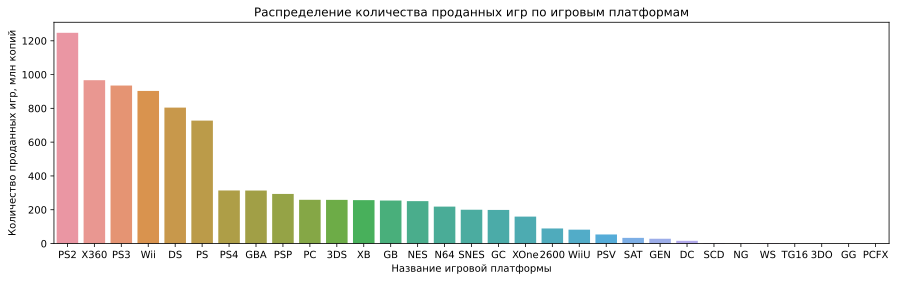

In [55]:
sales_on_platform = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False)
plt.figure(figsize=(15,4))
sns.barplot(x=sales_on_platform.index,y=sales_on_platform['total_sales'])
plt.title("Распределение количества проданных игр по игровым платформам")
plt.xlabel("Название игровой платформы")
plt.ylabel("Количество проданных игр, млн копий");

Отмечаем, что самыми популярными являются всего шесть игровых платформ:

In [56]:
sales_on_platform_top6 = sales_on_platform.head(6)
sales_on_platform_top6.sum()
print(sales_on_platform_top6)
print(f'Полное количество игр, разработанных с 1980 по 2016 год: {float(sales_on_platform.sum())/1000:.3f} млрд.')
print(f'Из них всего на шести платформах разрамещено: {float(sales_on_platform_top6.sum())/1000:.3f} млрд.')
print(f'Что составляет : {float(sales_on_platform_top6.sum())/float(sales_on_platform.sum()):.0%}.')

          total_sales
platform             
PS2           1247.16
X360           966.61
PS3            935.19
Wii            903.31
DS             804.28
PS             727.58
Полное количество игр, разработанных с 1980 по 2016 год: 8.870 млрд.
Из них всего на шести платформах разрамещено: 5.584 млрд.
Что составляет : 63%.


По количеству проданных игр они в разы опережают ближайших конкурентов и занимают около 2/3 многомиллиардного рынка!

Рассмотри этих лидеров подробнее:

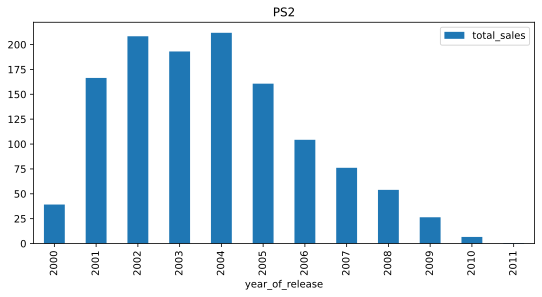

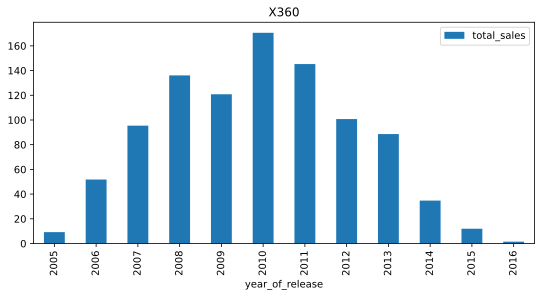

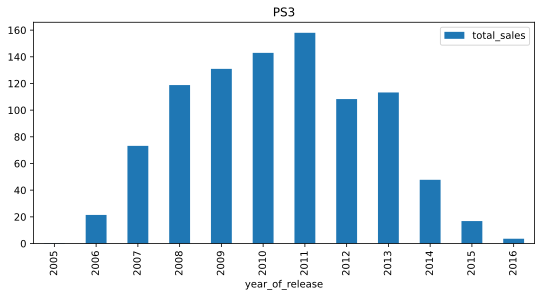

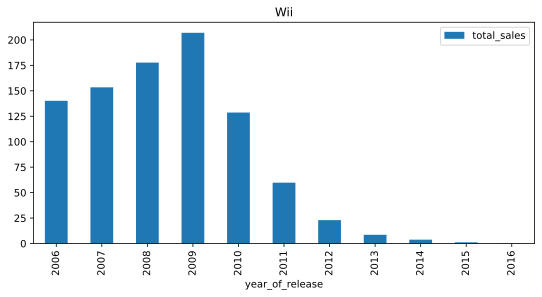

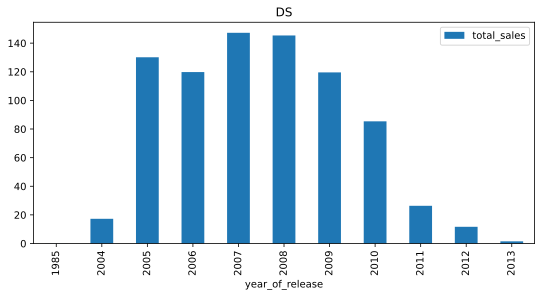

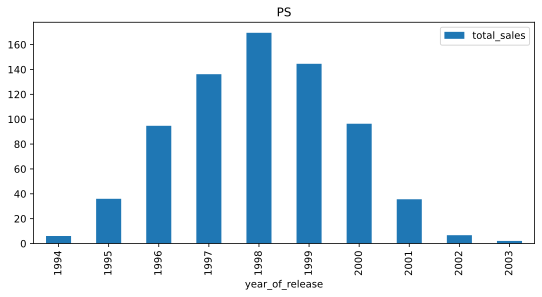

In [57]:
platform_grouped = sales_on_platform_top6.reset_index()
#Составим список всех платформ.
top_platforms_list = platform_grouped['platform'].unique()
for platform in top_platforms_list:
    data[data['platform'] == platform].pivot_table(index='year_of_release', 
        values='total_sales', aggfunc='sum').plot(kind='bar', figsize=(9,4))
    plt.title(platform)

Отметим, что время жизни бизнеса игровых платформ не превышает 8 - 10 лет и все самые популярные игровые платформы в 2016 году потеряли свой рынок. Поэтому в дальнейшем анализе их можно не рассматривать.

**3.3.3. Определим самые популярные и успешные платформы, оставшиеся на рынке к 2016 году**

Посмотрим, какие платформы активно работают (с продажами более 5 млн игр в год) в последние 3 года:

In [58]:
last_3years_data = data[data['year_of_release'] > 2013]
last_3years_data = last_3years_data[data['total_sales'] > 5]
last_3years_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
96,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,NaN,7.55
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN,7.39
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17


In [59]:
last_3years_data['platform'].describe()

count      18
unique      5
top       PS4
freq       10
Name: platform, dtype: object

Видим, что успешных платформ становится все меньше и меньше.
Стабильно на рынке присутствует лишь PS4 и в разные годы к ней примыкают XOne, 3DS, WiiU и PS3.

**3.3.4. Изучим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.**

Посчитаем корреляцию между отзывами и продажами на примере *Sony Play Station* (платформа PS4).

In [60]:
sony_play_station4 = data[data['platform']=='PS4']
sony_play_station4['user_score'].corr(sony_play_station4['total_sales'])

-0.03195711020455643

In [61]:
sony_play_station4['critic_score'].corr(sony_play_station4['total_sales'])

0.4065679020617816

Попробуем рассчитать такие коэффициенты коррелии *для всех* более-менее успешных, оставшихся на рынке платформ.

Сделаем функцию для расчеты коэффициента корреляции:
    

In [62]:
def calc_corr_platform(name_platform):
    platform = data[data['platform'] == name_platform]
    
    corr_user = platform['user_score'].corr(platform['total_sales'])
    corr_critic = platform['critic_score'].corr(platform['total_sales'])
    
#    print('Платформа: ', name_platform)
    print(f'Платформа: {name_platform:7} corr_user = {corr_user:6.3f},    corr_critic = {corr_critic:6.3f}.')   

In [63]:
for platform in ['PS4', 'XOne', '3DS', 'WiiU', 'PS3']:
    calc_corr_platform(platform)

Платформа: PS4     corr_user = -0.032,    corr_critic =  0.407.
Платформа: XOne    corr_user = -0.069,    corr_critic =  0.417.
Платформа: 3DS     corr_user =  0.222,    corr_critic =  0.348.
Платформа: WiiU    corr_user =  0.400,    corr_critic =  0.348.
Платформа: PS3     corr_user =  0.128,    corr_critic =  0.432.


Интересно, что для всех исследуемых платформ наблюдается умеренная корреляция между оценкой критиков и количеством проданных игр. Видимо, покупатели принимают во внимание рекомендации специалистов.

Для четырех платформ корреляция между мнением пользователй или не выявлена, или она очень слабая. Исключение составляет платформа WiiU.

WiiU — название игровой консоли Nintendo, которая является преемником Wii. Система была выпущена в 2012 году. 
Стоит отметить для этой платформы удивительное единодушие пользователй и критиков. Возможно, это произошло потому, что одной из целей WiiU было привлечь более серьёзную игровую аудиторию. 



**3.4 Изучим распределение продаж игр по жанрам для всех регионов мира**

In [64]:
choose_genre = last_3years_data.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False).reset_index().rename_axis(None, axis=1)
choose_genre

,genre,total_sales
0,Shooter,53.95
1,Role-Playing,25.99
2,Sports,22.26
3,Action,18.09
4,Fighting,7.55
5,Racing,7.09
6,Misc,5.27


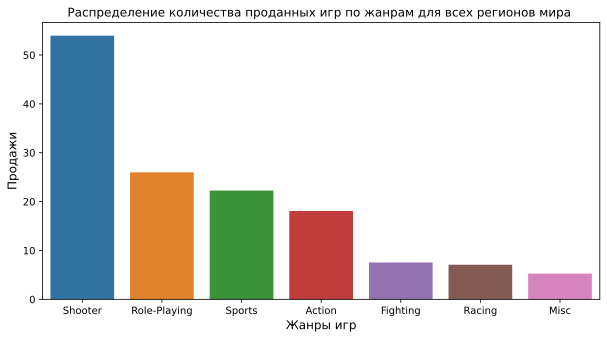

In [65]:
# Отобразим эти данные в виде гистограммы:
plt.figure(figsize=(10,5))
plt.title('Распределение количества проданных игр по жанрам для всех регионов мира ',fontsize=12)
sns.barplot(data=choose_genre, x='genre', y='total_sales')
plt.xlabel('Жанры игр',fontsize=12)
plt.ylabel('Продажи',fontsize=12);

Видим, что с большим преимуществом лидируют *стрелялки*. За ними отдельной группой следуют *ролевые игры*, *спортивные* и *экшн-игры*.

### 4 Портрет пользователя каждого региона

**4.1. Северная Америка**

**4.1.1. Наиболее популярные в Северной Америке игровые платформы**

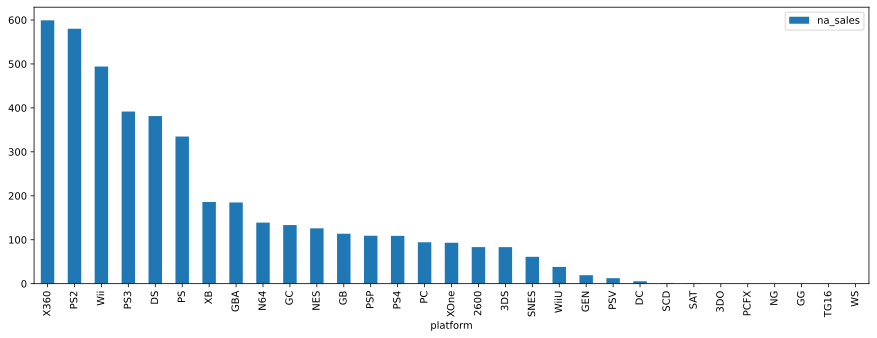

In [66]:
data.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum'). \
    sort_values(ascending=False, by = 'na_sales').plot(kind = 'bar', figsize=(15,5));

В Северной Америке самыми популярными можно выделить 6 игровых платформ:
* X360 - игровая приставка компании Microsoft: https://www.ixbt.com/consoles/xbox360_review.shtml
* PS2  - игровая приставка, выпущенная компанией Sony, наследница PlayStation и предшественница PlayStation 3: https://habr.com/ru/post/544488/
* Wii  - игровая приставка компании Nintendo: https://habr.com/ru/post/101009/
* PS3  - игровая приставка Sony, третья основная в семействе игровых систем PlayStation: https://habr.com/ru/post/586752/
* DS   - портативная игровая консоль с двумя экранами, разработана и производится компанией Nintendo: https://habr.com/ru/post/517476/
* PS   - игровая приставка, выпущенная компанией Sony: https://habr.com/ru/post/120892/

В абсолютном исчислении наиболее популярна в Северной Америке игровая приставка X360 производства Microsoft.
Но вот следующие 5 лидеров продаж в Севе5рной Америке - это продукт японских компаний.  Суммарно они значительно превосходят продажи X360!


**4.1.2. Самые популярные жанры компьютерных игр в Северной Америке**

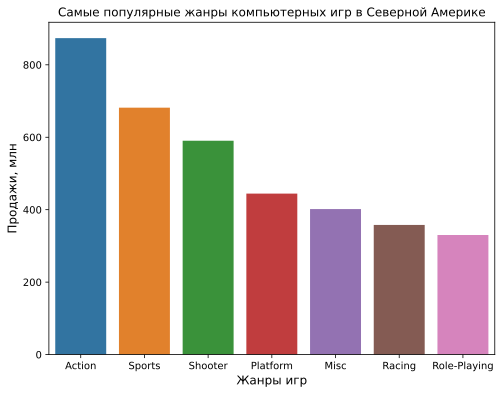

In [67]:
genre_na = data.pivot_table(index='genre', values='na_sales', aggfunc='sum'
                  ).sort_values(by='na_sales', ascending=False).reset_index().rename_axis(None, axis=1).head(7)
plt.figure(figsize=(8,6))
sns.barplot(data=genre_na, x='genre', y='na_sales')
plt.title('Самые популярные жанры компьютерных игр в Северной Америке',fontsize=12)
plt.xlabel('Жанры игр',fontsize=12)
plt.ylabel('Продажи, млн',fontsize=12);

В Северной Америке самыми популярными можно выделить 7 игровых жанров:
* Action - *экшен или боевик*. Акцент на борьбе, включает в себя прохождение определённых, все более высоких уровней.
* Sports  - спортивный *симулятор*. Соревнования по различным существующим видам спорта.
* Shooter  - *стрелялка*. Жанр компьютерной игры основан на стрельбе и уничтожении врагов.
* Platform - *платфо́рмер*, жанр компьютерных игр, в которых основу игрового процесса составляют прыжки по платформам, лазанье по лестницам, сбор предметов, необходимых для победы над врагами или завершения уровня.
* Misc - полное название жанра - Miscellaneous.  Дословно сме́шанный или разнообра́зный. Такие игры не могут быть точно отнесены к одной из конкретных веток, и объединены в жанр *смесь*.
* Racing - *гонялки*. Соревнования на время между персонажами или транспортными средствами.
* Role-Playing - *ролевая* игра. Сосредоточена на решении проблем, взаимодействии с неигровыми персонажами, участии в боях, развитии персонажа.

С классификацией компьютерных игр можно ознакомиться здесь: https://ru.wikipedia.org/wiki/Классификация_компьютерных_игр

**4.1.3. Изучим влияние рейтинга ESRB на продажи в Северной Америке**

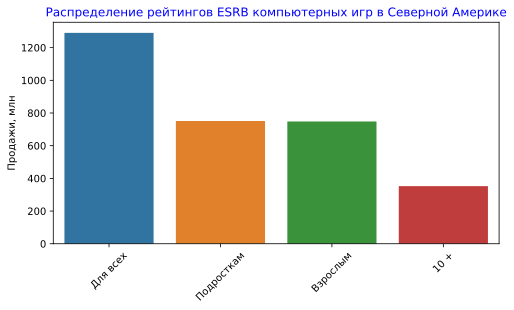

In [68]:
rating_na = data.pivot_table(index='rating', values='na_sales', aggfunc='sum'
                  ).sort_values(by='na_sales', ascending=False).reset_index().rename_axis(None, axis=1).head(4)

rating_full_name(rating_na) # создадим колонку rating_full_name

#plt.figure(figsize=(10,6))
#sns.barplot(data=rating_na, x='rating_full_name', y='na_sales')
#plt.title('Распределение рейтингов ESRB компьютерных игр в Северной Америке',fontsize=12)
#plt.xlabel('')
#plt.ylabel('Продажи, млн',fontsize=12);

fig, axis = plt.subplots(1, 1, figsize=(8,4))

sns.barplot(data=rating_na, x='rating', y='na_sales', ax=axis)
axis.set_xticklabels(rating_na['rating_full_name'], rotation=45)
axis.set_ylabel('Продажи, млн');
axis.set_xlabel('')
plt.title('Распределение рейтингов ESRB компьютерных игр в Северной Америке', color = 'Blue', fontsize=12);

Согласно рейтингу ESRB, в Северной Америке:
* Больше всех продается игр категории *Для всех*.
* Примерно на 1/3 отстают игры категорий 'Подросткам' и 'Для взрослых'
* Половину продаж от них составляет категория игр 'Для всех от 10 лет и старше'

**4.2. Европа**

**4.2.1. Наиболее популярные в Европе игровые платформы**

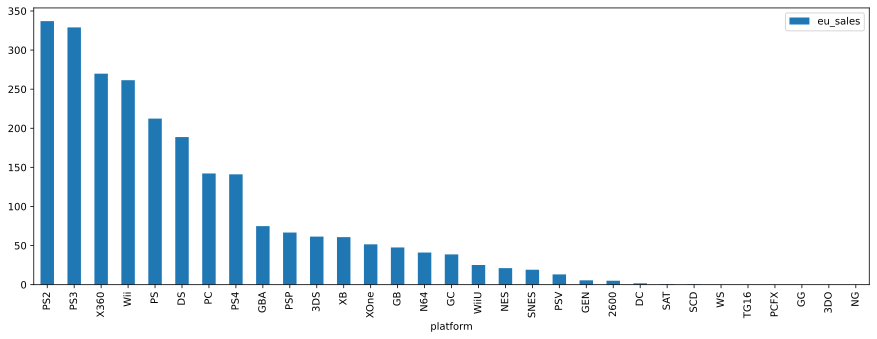

In [69]:
data.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum'). \
    sort_values(ascending=False, by = 'eu_sales').plot(kind = 'bar', figsize=(15,5));

У пользователей Европы популярны и японские платформы, и американская консоль Xbox360. В целом запросы такие же как у пользователей из Северной Америки.

**4.2.2. Самые популярные жанры компьютерных игр среди европейских стран**

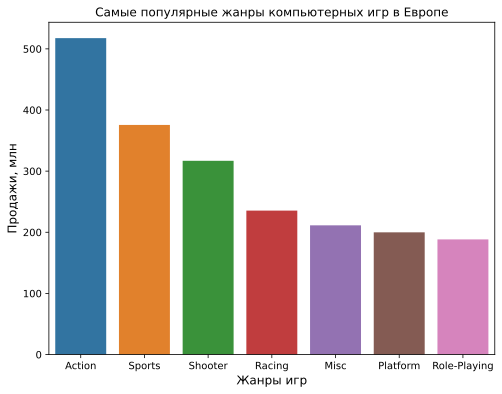

In [70]:
genre_eu = data.pivot_table(index='genre', values='eu_sales', aggfunc='sum'
                  ).sort_values(by='eu_sales', ascending=False).reset_index().rename_axis(None, axis=1).head(7)
plt.figure(figsize=(8,6))
sns.barplot(data=genre_eu, x='genre', y='eu_sales')
plt.title('Самые популярные жанры компьютерных игр в Европе',fontsize=12)
plt.xlabel('Жанры игр',fontsize=12)
plt.ylabel('Продажи, млн',fontsize=12);


В Европе самыми популярными можно выделить 7 игровых жанров:

* Action - экшен или боевик. Акцент на борьбе, включает в себя прохождение определённых, все более высоких уровней.
* Sports - спортивный симулятор. Соревнования по различным существующим видам спорта.
* Shooter - стрелялка. Жанр компьютерной игры основан на стрельбе и уничтожении врагов.
* Racing - *гонялки*. Соревнования на время между персонажами или транспортными средствами
* Misc - полное название жанра - Miscellaneous. Дословно сме́шанный или разнообра́зный. Такие игры не могут быть точно отнесены к одной из конкретных веток, и объединены в жанр смесь.
* Platform - *платфо́рмер*, жанр компьютерных игр, в которых основу игрового процесса составляют прыжки по платформам, лазанье по лестницам, сбор предметов, необходимых для победы над врагами или завершения уровня.
* Role-Playing - *ролевая* игра. Сосредоточена на решении проблем, взаимодействии с неигровыми персонажами, участии в боях, развитии персонажа.

С классификацией компьютерных игр можно ознакомиться здесь: https://ru.wikipedia.org/wiki/Классификация_компьютерных_игр

**4.2.3. Посмотрим влияние рейтинга ESRB на продажи в Европе**

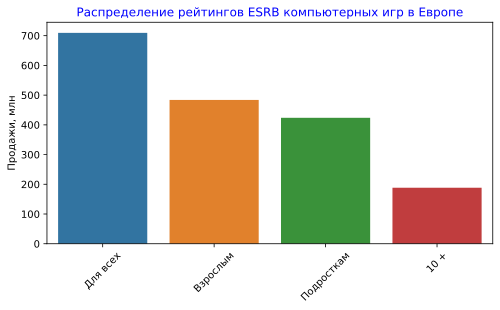

In [71]:
rating_eu = data.pivot_table(index='rating', values='eu_sales', aggfunc='sum'
                  ).sort_values(by='eu_sales', ascending=False).reset_index().rename_axis(None, axis=1).head(4)

rating_full_name(rating_eu) # создадим колонку rating_full_name

#plt.figure(figsize=(10,6))
#sns.barplot(data=rating_eu, x='rating_full_name', y='eu_sales')
#plt.title('Распределение рейтингов ESRB компьютерных игр в Европе',fontsize=12)
#plt.xlabel('')
#plt.ylabel('Продажи, млн',fontsize=12);

fig, axis = plt.subplots(1, 1, figsize=(8,4))

sns.barplot(data=rating_eu, x='rating', y='eu_sales', ax=axis)
axis.set_xticklabels(rating_eu['rating_full_name'], rotation=45)
axis.set_ylabel('Продажи, млн');
axis.set_xlabel('')
plt.title('Распределение рейтингов ESRB компьютерных игр в Европе', color = 'Blue', fontsize=12);

Согласно рейтингу ESRB, в Европе :
* Лидируют продажи игр категории Для всех.
* На втором месте по уровню продаж категория 'Для взрослых'.
* Совсем немного уступает ей категория 'Подросткам'.
* Замыкает список продаж категория игр 'Для всех от 10 лет и старше'

**4.3. Япония**

**4.3.1. Наиболее популярные в Японии игровые платформы**

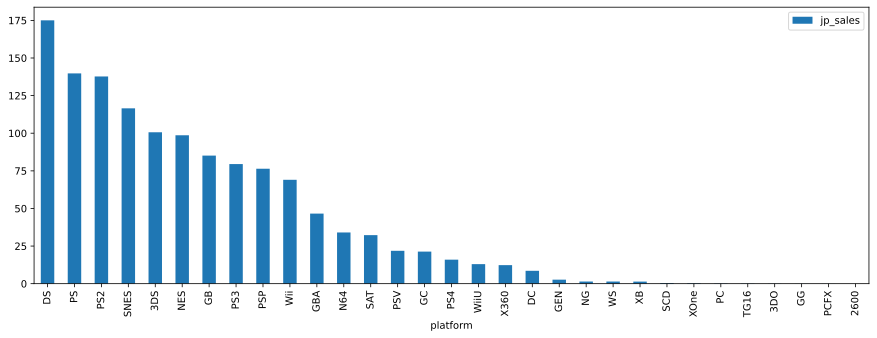

In [72]:
data.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum'). \
    sort_values(ascending=False, by = 'jp_sales').plot(kind = 'bar', figsize=(15,5));

Подавляющее большинство японских пользователей играют на японских игровых платформах, что неудивительно из-за большого их разнообразия.

**4.3.2. Самые популярные жанры компьютерных игр в Японии**

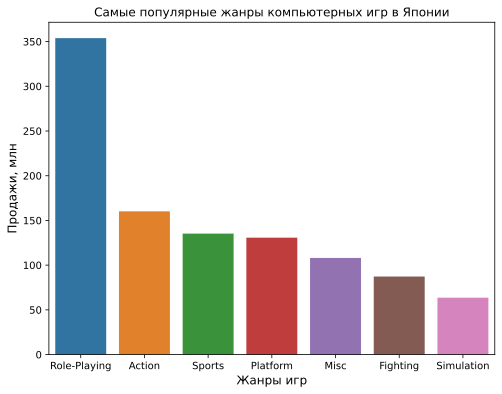

In [73]:
genre_jp = data.pivot_table(index='genre', values='jp_sales', aggfunc='sum'
                  ).sort_values(by='jp_sales', ascending=False).reset_index().rename_axis(None, axis=1).head(7)
plt.figure(figsize=(8,6))
sns.barplot(data=genre_jp, x='genre', y='jp_sales')
plt.title('Самые популярные жанры компьютерных игр в Японии',fontsize=12)
plt.xlabel('Жанры игр',fontsize=12)
plt.ylabel('Продажи, млн',fontsize=12);

В Японии самыми популярными можно выделить 7 игровых жанров:

* Role-Playing - *ролевая* игра. Сосредоточена на решении проблем, взаимодействии с неигровыми персонажами, участии в боях, развитии персонажа.
* Action - экшен или боевик. Акцент на борьбе, включает в себя прохождение определённых, все более высоких уровней.
* Sports - спортивный симулятор. Соревнования по различным существующим видам спорта.
* Platform - *платфо́рмер*, жанр компьютерных игр, в которых основу игрового процесса составляют прыжки по платформам, лазанье по лестницам, сбор предметов, необходимых для победы над врагами или завершения уровня.
* Misc - полное название жанра - Miscellaneous. Дословно сме́шанный или разнообра́зный. Такие игры не могут быть точно отнесены к одной из конкретных веток, и объединены в жанр смесь.
* Fighting — (бой, драка, поединок, борьба), жанр компьютерных игр, имитирующих рукопашный бой на спортивной арене.
* Simulator - разновидность компьютерной игры, эмитирующих управление, как правило, транспортным средством.

С классификацией компьютерных игр можно ознакомиться здесь: https://ru.wikipedia.org/wiki/Классификация_компьютерных_игр

**4.3.3. Рассмотрим влияние рейтинга ESRB на продажи в Японии**

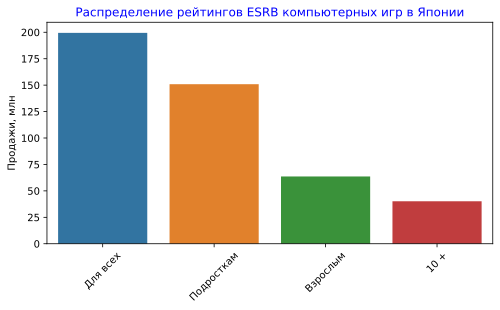

In [74]:
rating_jp = data.pivot_table(index='rating', values='jp_sales', aggfunc='sum'
                  ).sort_values(by='jp_sales', ascending=False).reset_index().rename_axis(None, axis=1).head(4)

rating_full_name(rating_jp) # создадим колонку rating_full_name

#plt.figure(figsize=(10,6))
#sns.barplot(data=rating_jp, x='rating_full_name', y='jp_sales')
#plt.title('Распределение рейтингов ESRB компьютерных игр в Японии',fontsize=12)
#plt.xlabel('')
#plt.ylabel('Продажи, млн',fontsize=12);

fig, axis = plt.subplots(1, 1, figsize=(8,4))

sns.barplot(data=rating_jp, x='rating', y='jp_sales', ax=axis)
axis.set_xticklabels(rating_jp['rating_full_name'], rotation=45)
axis.set_ylabel('Продажи, млн');
axis.set_xlabel('')
plt.title('Распределение рейтингов ESRB компьютерных игр в Японии', color = 'Blue', fontsize=12);

Согласно рейтингу ESRB, в Японии:
* Больше всех продается игр категории *Для всех*.
* Примерно четверть успупает ей категория 'Подросткам'.
* Продажи категории 'Для взрослых' меньше лидера в 3 раза и в 2,5 раза меньше второго места.
* Замыкает список продаж категория игр 'Для всех от 10 лет и старше'

**4.4. Сравнительный анализ распределения рейтингов компьютерных игр ESRB по различным регионам.**

Построим рядом 3 гистограммы с результатами продаж компьютерных игр, согласно категориям ESRB для трех различных регионов

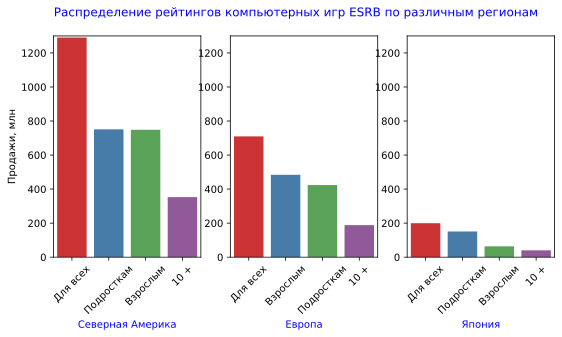

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))
sns.set_palette('Set1')

list_df = [rating_na, rating_eu, rating_jp]
list_regions = ['Северная Америка', 'Европа', 'Япония']
list_sales = ['na_sales', 'eu_sales', 'jp_sales']

for i in range(len(list_df)):
    sns.barplot(data=list_df[i], x='rating', y=list_sales[i], ax=axes[i])
    axes[i].set_xticklabels(list_df[i]['rating_full_name'], rotation=45)
    axes[i].set_xlabel(list_regions[i], color = 'Blue')
    axes[i].set_ylabel('Продажи, млн') if i == 0 else axes[i].set_ylabel('')    
    axes[i].set_ylim([0, 1300])

fig.suptitle('Распределение рейтингов компьютерных игр ESRB по различным регионам', 
             color = 'Blue', fontsize=12);

Прежде всего стоит отметить большую разницу в количестве продаж между регионами:
* В Европе компьютерными играми увлекаются примерно вдвое меньше людей, чем в Северной Америке, хотя население Европы раза в 2 больше, чем в Северной Америке.
* Продажи компьютерных игр в Японии меньше американских раз в 6-7, тогда как население Японии меньше, чем в Северной Америке всего лишь раза в 3.
* Можно предположить, что реклама и маркетинг сильнее работают именно в Северной Америке, поэтому там и самые высокие продажи компьютерных игр.
* Можно судить о том, что больше всего увлекаются компьютерными играми в Северной Америке. Тут интересно отметить, что, как определили ранее, в Японии их производят больше, чем где бы ни было, но используют меньше. Видимо, японцы больше работают, чем развлекаются, по сравнению с жителями других исследуемых регионов.
* Трудно не заметить наибольший, среди исследуемых регионов, интерес к играм "для взрослых" в Северной Америке. 

**4.5. Сравнительный анализ распределения продаж компьютерных игр по жанрам в различных регионах.**

Пойдем тем же путем и построим рядом 3 гистограммы с результатами продаж компьютерных игр, распределенных по жанрам, для трех различных регионов

**4.5.1. Изучим списки игр, наиболее популярных в каждом из регионов:**

In [76]:
# в Северной Америке:
genre_na

,genre,na_sales
0,Action,873.70
1,Sports,681.69
2,Shooter,590.35
3,Platform,444.44
4,Misc,401.69
5,Racing,357.90
6,Role-Playing,330.12


In [77]:
# в Европе:
genre_eu

,genre,eu_sales
0,Action,517.58
1,Sports,375.60
2,Shooter,316.96
3,Racing,235.47
4,Misc,211.32
5,Platform,199.87
6,Role-Playing,188.30


In [78]:
# в Японии:
genre_jp

,genre,jp_sales
0,Role-Playing,353.88
1,Action,160.15
2,Sports,135.27
3,Platform,130.71
4,Misc,108.04
5,Fighting,87.28
6,Simulation,63.64


Видим, что списки по Северной Америке и Европе полностью одинаковы.

А вот в японском списке есть *Fighting* и *Simulation* вместо *Shooter* и *Racing*

Принимаем решение - ничего не терять, объединить самые популярные жанры во всех регионах, создать список из 9 жанров и проводить сравнение по нему:
* Action
* Sports	
* Shooter
* Platform
* Misc
* Racing
* Role-Playing
* Fighting	
* Simulation	

**4.5.2. Добавим в список игр, наиболее популярных в Северной Америке данные по *Fighting* и *Simulation* :**

Найдем данные по этим двум полям:

In [79]:
data.pivot_table(index='genre', values='na_sales', aggfunc=['sum'])

,sum
,na_sales
genre,
Action,873.70
Adventure,101.52
Fighting,221.20
Misc,401.69
Platform,444.44
Puzzle,121.69
Racing,357.90
Role-Playing,330.12


Добавим в таблицу *na_sales* строку *Fighting = 221.20, Simulation = 180.85*

In [80]:
row = {'genre': 'Fighting', 'na_sales': 221.20}
genre_na = genre_na.append(row, ignore_index=True)
row = {'genre': 'Simulation', 'na_sales': 180.85}
genre_na = genre_na.append(row, ignore_index=True)
genre_na

,genre,na_sales
0,Action,873.70
1,Sports,681.69
2,Shooter,590.35
3,Platform,444.44
4,Misc,401.69
5,Racing,357.90
6,Role-Playing,330.12
7,Fighting,221.20
8,Simulation,180.85


Хорошо, теперь откорректируем *eu_sales*

**4.5.3. Добавим в список игр, наиболее популярных в Европе данные по Fighting и Simulation :**

Найдем данные по этим двум полям:

In [81]:
data.pivot_table(index='genre', values='eu_sales', aggfunc=['sum'])

,sum
,eu_sales
genre,
Action,517.58
Adventure,63.22
Fighting,99.19
Misc,211.32
Platform,199.87
Puzzle,49.82
Racing,235.47
Role-Playing,188.30


In [82]:
row = {'genre': 'Fighting', 'eu_sales': 99.19}
genre_eu = genre_eu.append(row, ignore_index=True)
row = {'genre': 'Simulation', 'eu_sales': 113.37}
genre_eu = genre_eu.append(row, ignore_index=True)
genre_eu

,genre,eu_sales
0,Action,517.58
1,Sports,375.60
2,Shooter,316.96
3,Racing,235.47
4,Misc,211.32
5,Platform,199.87
6,Role-Playing,188.30
7,Fighting,99.19
8,Simulation,113.37


Замечательно! Перейдем к *jp_sales*

**4.5.3. Добавим в список игр, наиболее популярных в Японии данные по Shooter и Racing :**

Найдем данные по этим двум полям:

In [83]:
data.pivot_table(index='genre', values='jp_sales', aggfunc=['sum'])

,sum
,jp_sales
genre,
Action,160.15
Adventure,52.24
Fighting,87.28
Misc,108.04
Platform,130.71
Puzzle,56.68
Racing,56.64
Role-Playing,353.88


In [84]:
row = {'genre': 'Shooter', 'jp_sales': 38.70}
genre_jp = genre_jp.append(row, ignore_index=True)
row = {'genre': 'Racing', 'jp_sales': 56.64}
genre_jp = genre_jp.append(row, ignore_index=True)
genre_jp

,genre,jp_sales
0,Role-Playing,353.88
1,Action,160.15
2,Sports,135.27
3,Platform,130.71
4,Misc,108.04
5,Fighting,87.28
6,Simulation,63.64
7,Shooter,38.70
8,Racing,56.64


4.5.4. Теперь построим сравнительные гистограммы:

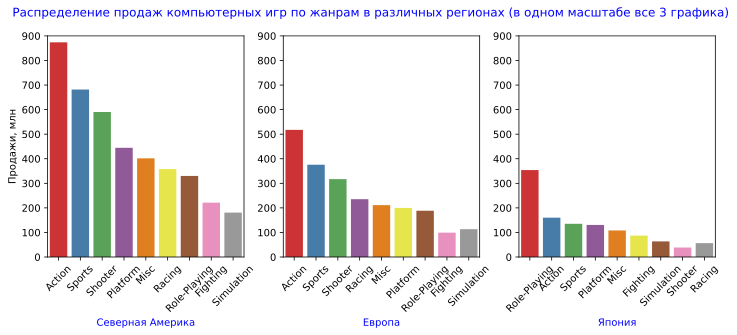

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.set_palette('Set1')

list_df = [genre_na, genre_eu, genre_jp]
list_regions = ['Северная Америка', 'Европа', 'Япония']
list_sales = ['na_sales', 'eu_sales', 'jp_sales']

for i in range(len(list_df)):
    sns.barplot(data=list_df[i], x='genre', y=list_sales[i], ax=axes[i])
    axes[i].set_xticklabels(list_df[i]['genre'], rotation=45)
    axes[i].set_xlabel(list_regions[i], color = 'Blue')
    axes[i].set_ylabel('Продажи, млн') if i == 0 else axes[i].set_ylabel('')    
    axes[i].set_ylim([0, 900])
    
fig.suptitle('Распределение продаж компьютерных игр по жанрам в различных регионах (в одном масштабе все 3 графика)', 
             color = 'Blue', fontsize=12);

**Предварительные выводы распределения продаж компьютерных игр по жанрам:**

Изобразив 3 графика в одном масштабе, мы видим, насколько сильно отличаются объемы продаж по разным регионам:
* Продажи в одной только Северной Америке превышают суммарные продажи в Европе и Японии.
* Продажи в Америке превышают продажи в Японии раза в 3. Примерно такая же разница в населении. Получается, что количество игр на душу населения, продаваемый в Северной Америке и Японии находится на одном уровне.
* А вот население Европы раза в 2 превышает население Северной Америки, а играют они раза в два реже. Видимо, европейцы не так сильно подвержены игромании, а реклама и маркетинг игровой индустрии в других региогнах развиты сильнее.

**Подробнее посмотрим на жанры, предпочитаемые людьми в разных регионах.**

Для этого построим все 3 графика заново с автоматическим масштабированием:

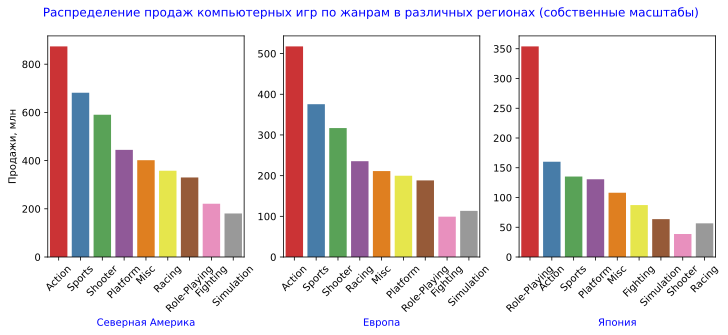

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(len(list_df)):
    sns.barplot(data=list_df[i], x='genre', y=list_sales[i], ax=axes[i])
    axes[i].set_xticklabels(list_df[i]['genre'], rotation=45)
    axes[i].set_xlabel(list_regions[i], color = 'Blue')
    axes[i].set_ylabel('Продажи, млн') if i == 0 else axes[i].set_ylabel('')    
    
fig.suptitle('Распределение продаж компьютерных игр по жанрам в различных регионах (собственные масштабы)', 
             color = 'Blue', fontsize=12);

**По предпочтениям жителей разных регионов можно сделать определенные выводы:**
* Вкусы у американцев и европейцев совпадают. Лидеры среди жанров: *Action*, *Sports*, *Shooter*
* Японцы больше любят *ролевые игры*. И довольно редко в жанре *Shooter*.
* Популярность ролевых игр в Японии объясняется тем, что есть специальный жанр японских ролевых игр (JRPG), которые сделаны в стилистике аниме, что очень привлекательно для японцев. Источник: https://neolurk.org/wiki/RPG



### 5 Проверка гипотез

**5.1. Проверка гипотезы "Средние пользовательские рейтинги платформ *Xbox One* и *PC* одинаковые"**

**Сформулируем нулевую и альтернативную гипотезы:**
* Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются       

In [87]:
# Создадим переменную с пользовательскими оценками платформы Xbox One и
# для последующей работы с ней очистим от пропущенных значений:
rating_xboxOne = data[data['platform']=='XOne']['user_score'].dropna()

In [88]:
# Создадим переменную с пользовательскими оценками платформы PC и
# для последующей работы с ней очистим от пропущенных значений:
rating_pc = data[data['platform']=='PC']['user_score'].dropna()

In [89]:
# Из интереса посмотрим усредненные значения пользовательских оценок:
print(f'Средние значения пользовательского рейтинга:')
print(f'- на платформе Xbox One: {rating_xboxOne.mean():.1f}')
print(f'- на платформе Xbox One: {rating_pc.mean():.1f}')

Средние значения пользовательского рейтинга:
- на платформе Xbox One: 6.5
- на платформе Xbox One: 7.1


In [90]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(rating_xboxOne, rating_pc, equal_var=False)

# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(f'p-значение: {results.pvalue:.1E}')

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.1E-06
Отвергаем нулевую гипотезу


**Вывод:**

Получив p-value на уровне 4e-06, мы отвергли Нулевую гипотезу. Таким образом, у нас нет вероятности получить одинаковые средние рейтинги платформ *Xbox One* и *PC*.

**5.2. Проверка гипотезы "Средние пользовательские рейтинги жанров *Action* и *Sports* разные"**

**Сформулируем нулевую и альтернативную гипотезы:**
* Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports разные.
* Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports одинаковые. 

In [91]:
# Создадим переменную с пользовательскими оценками жанра Action и
# для последующей работы с ней очистим от пропущенных значений:
genre_action = data[data['genre']=='Action']['user_score'].dropna()

In [92]:
# Создадим переменную с пользовательскими оценками жанра Spotrs и
# для последующей работы с ней очистим от пропущенных значений:
genre_sports = data[data['genre']=='Sports']['user_score'].dropna()

In [93]:
# Из интереса посмотрим усредненные значения пользовательских оценок:
print(f'Средние значения пользовательского рейтинга:')
print(f'- жанра Action: {genre_action.mean():.1f}')
print(f'- жанра Spotrs: {genre_sports.mean():.1f}')

Средние значения пользовательского рейтинга:
- жанра Action: 7.1
- жанра Spotrs: 7.0


In [94]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(genre_action, genre_sports, equal_var=False)

# alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(f'p-значение: {1 - results.pvalue:.2f}')

# условный оператор с выводом строки с ответом
if 1 - results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.91
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

Получив p-value на уровне 0.09, мы не отвергли Нулевую гипотезу. Таким образом, мы не опровергаем гипотезу о разности средних пользовательских рейтингов для жанров Action и Sports.

### 6 Общий вывод

**По результатам исследования можно отметить следующие интересные факты и сделать выводы:**

1.Для проведения исследования получены данные по продажам в Северной Америке, Европе и Японии компьютерных игр и приставок в период с 1980 по 2016 годы.


2.Массив данных записан в файле *games.csv*.


3.Установлено, что значения в файле разделены символом запятая.


4.Найдено, что в файле хранятся данные в количестве 16 715 строк на 11 столбцов.


5.Проверены и приведены к стилю *snake_case* названия столбцов.


6.Дублирующих строк среди данных нет.


7.Проверены и откорректированы типы данных:
    * поле year_of_release из типа float приведён к типу int.
    * поле user_score из типа object приведён к типу float.
    
    
8.В поле user_score обнаружены необычные значения 'tbd'. Предположили, что это означает to be discussed и заменили его на nan.


9.Из 11 столбцов заполнены полностью 7. Остальные 4 имеют пропущенные значения:
    * в поле name 2 пропуска. Идентифицировать эти две игры не удалось, поэтому две строки с пропущенными названиями игр были удалены.
    * в поле year_of_release найдены 269 пропусков. Удалось понять, что игры выпускались в один и тот же год на разных платформах и 123 пропуска были замещены корректными значениями.
    * пропуски в значениях оценки критиков (critic_score) и пользователей (user_score) заполнить по прошествии многих лет не представляется возможным. Количествр пропусков очень большое – около 50%, поэтому оставили эти значения без изменений и удалений, все, как в оригинальном файле.
    * в поле рейтинг компании ESRB (rating) обнаружены пропуски. Они вполне объяснимы, так как ESRB начала работать только в 1994 году (https://www.esrb.org/history/) поэтому игры, выпускаемые с 1980 года не имеют таких рейтингов.


10.Устранены повторения среди рейтингов ESRB:
    * три строки с рейтингом "K-A" ("Kids to Adults"). «Для всех» заменён на значительно более распространённое значение «E» («Everyone») — «Для всех».
    * одна строка с рейтингом «AO» («Adults Only 18+») — «Только для взрослых» объединена с категорией «M» («Mature») — «Для взрослых».


11.Создан словарь рейтингов ESRB (rating_ESRB) в виде “краткое обозначение рейтинга” – ключ, “полная расшифровка рейтинга” – значение.


12.Сделана подпрограмма rating_full_name для формирования в датасете столбца с полными названиями рейтингов.


13.Посчитано, что количество удалённых значений равно 148, что составляет 0.89% от общего объёма данных. Принято решение о приемлемости количества утерянных данных и продолжении исследования.


14.В исходный датасет data добавлен новый столбец, содержащий информацию о суммарных продажах, включая Северную Америку, Европу, Японию и другие страны. Единица измерения - миллионы проданных игр.


15.Установлено, что производство и выпуск новых компьютерных игр сильно увеличивался начиная с 1990 и до 2008 года, а затем так же резко стал падать. Это объясняется появлением новых компьютерных технологий и мобильных устройств.


16.Построен “ящик с усами” по глобальным продажам игр в разбивке по платформам. Выявлено наличие выбросов в области высоких значений продаж по всем платформам. Это подтверждает идею о неравномерности продаж компьютерных игр. За резким взлётом продаж новой игры следует сильный спад из-за появления более современных игр. 


17.Сделан вывод о том, что бизнес по продажам игр не равномерный, а скачкообразный. Вероятнее всего, с выходом новой игры ее продажи резко растут, а затем постепенно падают. Видимо, появляются новые игры, привлекающие покупателей, да и технологии тоже совершенствуются, делая новые игры более и более привлекательными.


18.Отмечено, что самыми популярными являются всего шесть игровых платформ: PS2, X360, PS3, Wii, Ds и PS. Они занимали 63% рынка.


19.Установлено, что время жизни бизнеса игровых платформ не превышает 8 - 10 лет и все самые популярные игровые платформы в 2016 году потеряли свой рынок. Да и общее количество игроков на рынке компьютерных игр сокращается. Мелких вытесняют гиганты.


20.Из оставшихся к 2016 году успешно работает лишь PS4, и в разные годы к ней примыкают XOne, 3DS, WiiU и PS3.


21.Изучено влияние отзывов критиков и пользователей на продажи в последние годы. 
    * Установлено, что для всех исследуемых лидирующих в последнее время платформ (PS4, XOne, 3DS, WiiU и PS3) наблюдается умеренная корреляция между оценкой критиков и количеством проданных игр. Покупатели принимают во внимание рекомендации специалистов. 
    * Для четырёх платформ корреляция между мнением пользователей или не выявлена, или она очень слабая. 
    * Исключение составляет платформа WiiU. WiiU — название игровой консоли Nintendo, которая является преемником Wii. Система была выпущена в 2012 году и одной из целей WiiU было привлечь более серьёзную игровую аудиторию, что видимо, и сказалось на отмеченном влиянии мнения пользователей на продажи.


22.Рассмотрено распределение продаж игр по жанрам для всех регионов мира.  С большим преимуществом лидируют стрелялки. За ними отдельной группой следуют ролевые игры, спортивные и экшн-игры.


23.Проверены тенденции в покупках компьютерных игр в различных регионах (Северная Америка, Европа и Япония).

    По Северной Америке установлено:
        - самыми популярными являются 6 игровых платформ: X360, PS2, Wii, PS3, DS, PS.
	В абсолютном исчислении наиболее популярна в Северной Америке игровая приставка X360 производства Microsoft. Но вот следующие 5 лидеров продаж в Севе5рной Америке - это продукт японских компаний. Суммарно они значительно превосходят продажи X360!
        - самые популярные 7 игровых жанров: Action, Sports, Shooter, Platform, Misc, Racing и Role-Playing.
        - согласно рейтингу ESRB:
            * Больше всех продается игр категории Для всех.
            * Примерно на 1/3 отстают игры категорий 'Подросткам' и 'Для взрослых'
            * Половину продаж от них составляет категория игр 'Для всех от 10 лет и старше'

	По Европе:
	- У пользователей Европы популярны и японские платформы, и американская консоль Xbox360. В целом запросы такие же как у пользователей из Северной Америки.
	- самые популярные 7 игровых жанров: Action, Sports, Shooter, Racing, Misc, Platform, и Role-Playing.
	- Согласно рейтингу ESRB:
		* Лидируют продажи игр категории Для всех.
		* На втором месте по уровню продаж категория 'Для взрослых'.
		* Совсем немного уступает ей категория 'Подросткам'.
		* Замыкает список продаж категория игр 'Для всех от 10 лет и старше

    Таким образом, отмечено, что игроки в Северной Америке и в Европе очень похожи и запросы к играм у них одинаковые.

	По Японии:
	- Подавляющее большинство японских пользователей играют на японских игровых платформах (Ds, PS, PS2, SNES, 3DS, NES …), что неудивительно из-за большого их разнообразия.
	- самые популярные 7 игровых жанров: Role-Playing, Action, Sports, Platform, Misc, Fighting, и Simulator.
	- Согласно рейтингу ESRB:
		* Больше всех продаётся игр категории ‘Для всех’.
		* Примерно четверть уступает ей категория 'Подросткам'.
		* Продажи категории 'Для взрослых' меньше лидера в 3 раза и в 2,5 раза меньше второго места.
		* Замыкает список продаж категория игр 'Для всех от 10 лет и старше'.


24.Проведён сравнительный анализ распределения рейтингов компьютерных игр ESRB по различным регионам.

	Отмечена большая разница в количестве продаж между регионами:
        * В Европе компьютерными играми увлекаются примерно вдвое меньше людей, чем в Северной Америке, хотя население Европы раза в 2 больше, чем в Северной Америке.
        * Продажи компьютерных игр в Японии меньше американских раз в 6-7, тогда как население Японии меньше, чем в Северной Америке всего лишь раза в 3.
        * Можно предположить, что реклама и маркетинг сильнее работают именно в Северной Америке, поэтому там и самые высокие продажи компьютерных игр.
        * Можно судить о том, что больше всего увлекаются компьютерными играми в Северной Америке. Тут интересно отметить, что, как определили ранее, в Японии их производят больше, чем где бы ни было, но используют меньше. Видимо, японцы больше работают, чем развлекаются, по сравнению с жителями других исследуемых регионов.
        * Отмечен наибольший, среди исследуемых регионов, интерес к играм "для взрослых" в Северной Америке.


25.Выполнен сравнительный анализ распределения продаж компьютерных игр по жанрам:

    * Продажи в одной только Северной Америке превышают суммарные продажи в Европе и Японии.
    * Продажи в Америке превышают продажи в Японии раза в 3. Примерно такая же разница в населении. Получается, что количество игр на душу населения, продаваемый в Северной Америке и Японии находится на одном уровне.
    * А вот население Европы раза в 2 превышает население Северной Америки, а играют они раза в два реже. Видимо, европейцы не так сильно подвержены игромании, а реклама и маркетинг игровой индустрии в других регионах развиты сильнее.


26.Установлены предпочтениям жителей разных регионов:

    * Вкусы у американцев и европейцев совпадают. Лидеры среди жанров: Action, Sports, Shooter
    * Японцы больше любят ролевые игры. И довольно редко в жанре Shooter.
    * Популярность ролевых игр в Японии объясняется тем, что есть специальный жанр японских ролевых игр (JRPG), которые сделаны в стилистике аниме, что очень привлекательно для японцев.


27.Проведена проверка гипотезы "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые".
	
    Нулевая гипотеза отвергнута. Нет вероятности получить одинаковые средние рейтинги платформ Xbox One и PC.


28.Проверена гипотеза "Средние пользовательские рейтинги жанров Action и Sports разные".

	 Гипотеза о разности средних пользовательских рейтингов для жанров Action и Sports не опровергнута.

[Вернутся к общему списку проектов курса “Data Science” Яндекс-практикума](../README.md)